# 01 Post process turbine simulation
## -- Flow field --

In [1]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as ncdf
import pandas as pd
import os

In [2]:
from moa_python.post_plane import Post_plane
from moa_python.post_turbine import Post_turbine

## Case with OpenFAST turbine

In [3]:
case_folder = '/projects/ssc/jfrederi/amr-wind-runs/precursor-reverted/baseline_8ms'
cases = ['baseline','ccwhelix_St03']
hor_plane_file = 'post_processing/samplingPlane14400.nc'
ver_plane_file = 'post_processing/samplingSlice14400.nc'

### Horizontal plane

In [6]:
full_filename_hor_plane = os.path.join(case_folder,hor_plane_file)
hor_plane = Post_plane(full_filename_hor_plane, origin = [480,480,0])

## Turbine parameters
D = 240
hub_height = 150
t = 10000
overhang = 12.0313
x0 = 2*D
y0 = 2*D
Nturb = 1
dist = 5*D

# Set origin and scale to rotor diameter
hor_plane.set_origin(x = x0, y = y0)
hor_plane.scale_to_rot_diam(D)

Plane has 1 plane(s) in 361 time steps from 7200.0 to 10799.999999965657
Plane offsets: [150.]


Plotting u velocity for plane at location 0.625 at time 10000
Nearest point to 0.625 is 0.625
Nearest time to 10000 is 9999.999999977299
Returning u velocity plane for slice at 0.625 at time 9999.999999977299


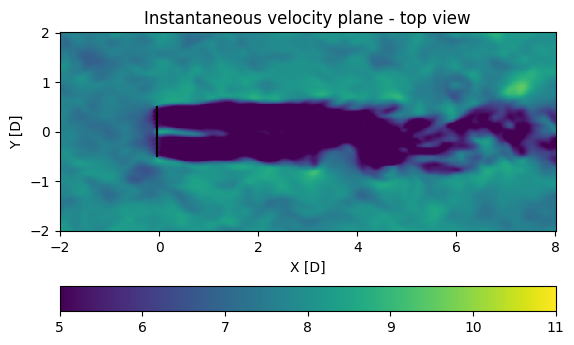

In [7]:
ax = hor_plane.plot_plane(z = hub_height/D, time = t, vmin=5., vmax=11.)
ax.set_title("Instantaneous velocity plane - top view");
for n in range(Nturb):
    hor_plane.plot_turbine(turb_loc = [(-overhang+n*dist)/D,0])

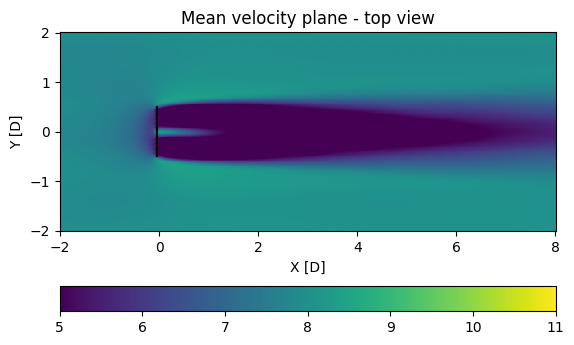

In [8]:
timespan = [9000, 10800]

ax = hor_plane.plot_mean_plane(z = hub_height/D, timespan = timespan, vmin=5., vmax=11., verbose = 0)
ax.set_title("Mean velocity plane - top view");
for n in range(Nturb):
    hor_plane.plot_turbine(turb_loc = [(-overhang+n*dist)/D,0])

### Vertical plane

In [9]:
full_filename_slice = os.path.join(case_folder,ver_plane_file)
ver_plane = Post_plane(full_filename_slice)

# Set origin and scale to rotor diameter
ver_plane.set_origin(center='x')
ver_plane.scale_to_rot_diam(D)

Plane has 4 plane(s) in 361 time steps from 7200.0 to 10799.999999965657
Plane offsets: [   0.  720. 1200. 1680.]


In [ ]:
fig,ax = plt.subplots(ver_plane.z_N, 1, figsize = (6,10), constrained_layout = True)
for n in range(ver_plane.z_N):
    ax[n] = ver_plane.plot_plane(ver_plane.z[n], t, ax = ax[n], vmin=5., vmax=11.)
    ver_plane.plot_turbine(turb_loc = [0, hub_height/D], plane = 'yz')
    ax[n].set_title(f'Cross section at {int(ver_plane.z[n])}D')
    im = [obj for obj in ax[n].get_children() if isinstance(obj, mpl.collections.Collection)][0]
    if im:
        im.colorbar.remove()
fig.colorbar(im,ax=ax,location='bottom');

Plotting u velocity for plane at location 0.0 at time 10000
Nearest point to 0.0 is 0.0
Nearest time to 10000 is 9999.999999977299
Returning u velocity plane for slice at 0.0 at time 9999.999999977299
Plotting u velocity for plane at location 3.0 at time 10000
Nearest point to 3.0 is 3.0
Nearest time to 10000 is 9999.999999977299
Returning u velocity plane for slice at 3.0 at time 9999.999999977299
Plotting u velocity for plane at location 5.0 at time 10000
Nearest point to 5.0 is 5.0
Nearest time to 10000 is 9999.999999977299
Returning u velocity plane for slice at 5.0 at time 9999.999999977299
Plotting u velocity for plane at location 7.0 at time 10000
Nearest point to 7.0 is 7.0
Nearest time to 10000 is 9999.999999977299
Returning u velocity plane for slice at 7.0 at time 9999.999999977299


In [ ]:
fig,ax = plt.subplots(ver_plane.z_N, 1, figsize = (6,10), constrained_layout = True)
for n in range(ver_plane.z_N):
    ax[n] = ver_plane.plot_mean_plane(ver_plane.z[n], timespan = timespan, ax = ax[n], vmin=5., vmax=11., verbose = 0)
    ver_plane.plot_turbine(turb_loc = [0, hub_height/D], plane = 'yz')
    ax[n].set_title(f'Cross section at {int(ver_plane.z[n])}D')
    im = [obj for obj in ax[n].get_children() if isinstance(obj, mpl.collections.Collection)][0]
    if im:
        im.colorbar.remove()
fig.colorbar(im,ax=ax,location='bottom');

## Wake analysis

In [ ]:
## Plot average wind speed in the wake
fig_wake, ax_wake = plt.subplots()

hor_plane.plot_vel_in_wake(radius = 1/2, turb_loc = [0, 0, 150/D], \
                           z= 150/D, timespan=[9000,10800], ax = ax_wake, verbose = 0)
ver_plane.plot_vel_in_wake(radius = 1/2, turb_loc = [0, 150/D, 0], \
                           timespan = [9000, 10800], axis='z', ax = ax_wake, linestyle = 'o', verbose = 0)
ax_wake.legend(['Streamwise @hub height','Cross section'])
ax_wake.set_title('Velocity in the wake');

In [ ]:
## Fit Gauss curve to the wake profile at 2D:7D
fig_prof, ax_prof = plt.subplots(6, 1, figsize = (6,10), tight_layout=True)
for n in range(6):
    popt = hor_plane.fit_gauss_to_wake_profile(n+2, time = t, fit='double', ax=ax_prof[n])
    ax_prof[n].set_ylim([2, 8.8])
    ax_prof[n].set_title(f'Wake profile at {n+2}D')

## -- OpenFAST turbine data --

In [4]:
turbine_files = ['IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.out']
full_filename_turbine_file = []
for n in range(len(turbine_files)):
    full_filename_turbine_file.append(os.path.join(case_folder,turbine_files[n]))
fast_out = Post_turbine(full_filename_turbine_file)

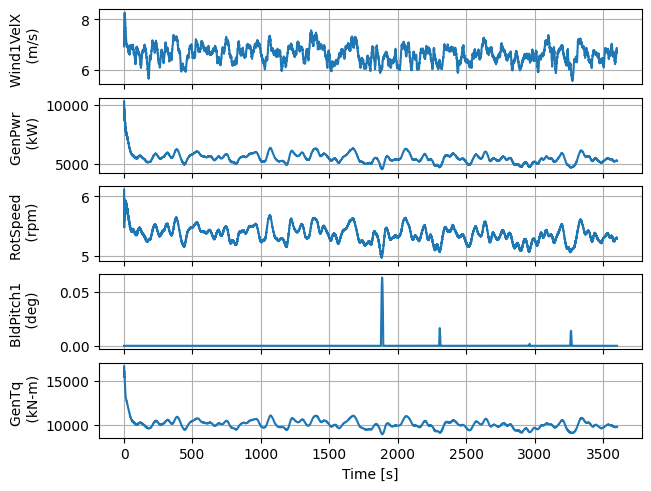

In [5]:
fig, axes = fast_out.plot_fast_out()